In [1]:
# Library
import pandas as pd
import numpy as np
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from main import model_z_1, model_z_2, model_z_3, model_z_4, model_z_5, model_z_6, model_z_7, model_z_8

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Real data
### Period 
1983-2018 Q
### Output gap
Beveridge-Nelson Filter's cycle component (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### The number of Firm
ECNSVY Business Dynamics Statistics (https://data.census.gov/table/BDSTIMESERIES.BDSGEO?q=Bussiness+dynamics+statistics)

---

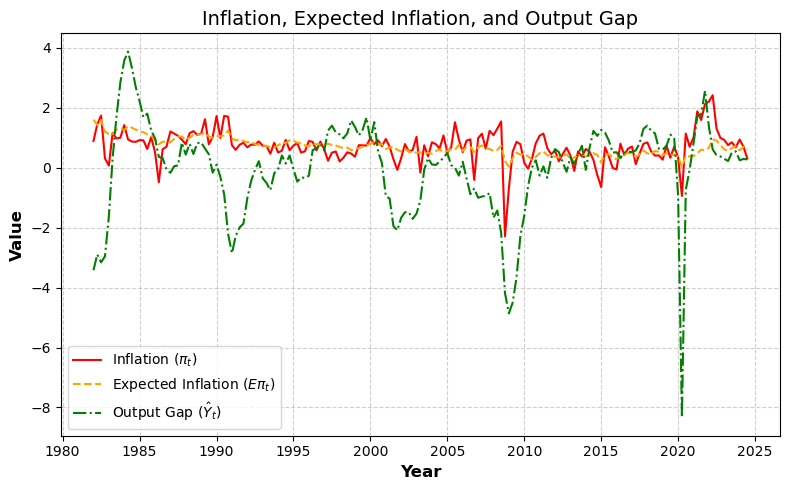

In [2]:
# Data cleaning and plot
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])


data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data.dropna(inplace=True)
# data = data[data['DATE'] < '2008-07-01']

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

# plot
plt.figure(figsize=(8, 5))
plt.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(data["DATE"], data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation parameters

In [13]:
warmup= 15
samples=10
chains = 2
rng_key = jax.random.PRNGKey(0)

## Estimated Models

In [14]:
model_0_0_text = r"""--- 
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
"""
model_0_1_text = r"""---
$$\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
"""
model_1_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_2_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_3_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_4_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_5_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_6_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_7_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_8_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""

dict_eq = {'Model-0-1':model_0_0_text,'Model-0-2':model_0_1_text,'Model-1':model_1_text, 'Model-2':model_2_text,'Model-3':model_3_text, 'Model-4':model_4_text,
           'Model-5':model_5_text,'Model-6':model_6_text, 'Model-7':model_7_text,'Model-8':model_8_text                                                                                                                                                         }
even_items = []  
odd_items = []   

for model_name, eq_text in dict_eq.items():
    eq_text_escaped = eq_text.replace("|", "\\|")
    eq_text_escaped = eq_text_escaped.replace("\n", "<br>")
    eq_text_escaped = eq_text_escaped.replace("---", "")
    eq_text_escaped = eq_text_escaped.replace("model", "")
    eq_text_escaped = eq_text_escaped.replace("Model", "")
    
    parts = model_name.split('-')
    last_part = parts[-1]
    try:
        number = int(last_part)
    except ValueError:
        number = None
    
    if number is not None and number % 2 == 0:
        even_items.append((model_name, eq_text_escaped))
    else:
        odd_items.append((model_name, eq_text_escaped))

markdown_lines = [
    "| Model | Model(Backward) |",
    "|-----------|-----------|"
]

max_rows = max(len(even_items), len(odd_items))
for i in range(max_rows):
    even_cell = ""
    odd_cell = ""
    if i < len(odd_items):
        odd_model_name, odd_eq = odd_items[i]
        odd_cell = f"**{odd_model_name}**<br>{odd_eq}"
    if i < len(even_items):
        even_model_name, even_eq = even_items[i]
        even_cell = f"**{even_model_name}**<br>{even_eq}"
    markdown_lines.append(f"| {odd_cell} | {even_cell} |")

markdown_table = "\n".join(markdown_lines)
display(Markdown(markdown_table))


| Model | Model(Backward) |
|-----------|-----------|
| **Model-0-1**<br> <br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br> | **Model-0-2**<br><br>$$\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br> |
| **Model-1**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-2**<br><br>$$\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |
| **Model-3**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-4**<br><br>$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |
| **Model-5**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-6**<br><br>$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |
| **Model-7**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-8**<br><br>$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |

In [15]:
# Model 1
kernel = NUTS(model_z_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_1 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()
# z
z_1_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_1_samples, axis=0)
z_std_1 = np.std(z_1_samples, axis=0)
z_lower_1 = z_mean_1 - 1.96 * z_std_1
z_upper_1 = z_mean_1 + 1.96 * z_std_1

# kappa
kappa_1_samples = posterior_samples["kappa"]
kappa_mean_1 = np.mean(kappa_1_samples, axis=0)
kappa_std_1 = np.std(kappa_1_samples, axis=0)
kappa_lower_1 = kappa_mean_1 - 1.96 * kappa_std_1
kappa_upper_1 = kappa_mean_1 + 1.96 * kappa_std_1

model_1_theta = posterior_samples["theta"].mean()
model_1_beta  = posterior_samples["beta"].mean()
model_1_gamma = posterior_samples["gamma"].mean()
model_1_rho_z = posterior_samples["rho_z"].mean()

result_1 = rf"""
$$\pi_{{t}} = {model_1_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{1,t}} Y_t - {model_1_theta:.4f}\, z_{{1,t}} + \epsilon_t$$
$$z_{{1,t}} = {model_1_gamma:.4f}\, z_{{1,t-1}} + \eta_t$$
$$\kappa_{{1,t}} = {model_1_rho_z:.4f}\, z_{{1,t-1}} + u_t$$
"""
display(Markdown(result_1))


# Model 2
kernel = NUTS(model_z_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_2 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_2_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_2_samples, axis=0)
z_std_2 = np.std(z_2_samples, axis=0)
z_lower_2 = z_mean_2 - 1.96 * z_std_2
z_upper_2 = z_mean_2 + 1.96 * z_std_2

kappa_2_samples = posterior_samples["kappa"]
kappa_mean_2 = np.mean(kappa_2_samples, axis=0)
kappa_std_2 = np.std(kappa_2_samples, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.96 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.96 * kappa_std_2

model_2_alpha = posterior_samples["alpha"].mean()
model_2_theta = posterior_samples["theta"].mean()
model_2_beta  = posterior_samples["beta"].mean()
model_2_gamma = posterior_samples["gamma"].mean()
model_2_rho_z = posterior_samples["rho_z"].mean()

result_2 = rf"""
$$\pi_{{t}} = {model_2_alpha:.4f}\, \pi_{{t-1}} + {model_2_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{2,t}} Y_t - {model_2_theta:.4f}\, z_{{2,t}} + \epsilon_t$$
$$z_{{2,t}} = {model_2_gamma:.4f}\, z_{{2,t-1}} + \eta_t$$
$$\kappa_{{2,t}} = {model_2_rho_z:.4f}\, z_{{2,t-1}} + u_t$$
"""
display(Markdown(result_2))


# Model 3
kernel = NUTS(model_z_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_3 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_3_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_3_samples, axis=0)
z_std_3 = np.std(z_3_samples, axis=0)
z_lower_3 = z_mean_3 - 1.96 * z_std_3
z_upper_3 = z_mean_3 + 1.96 * z_std_3

kappa_3_samples = posterior_samples["kappa"]
kappa_mean_3 = np.mean(kappa_3_samples, axis=0)
kappa_std_3 = np.std(kappa_3_samples, axis=0)
kappa_lower_3 = kappa_mean_3 - 1.96 * kappa_std_3
kappa_upper_3 = kappa_mean_3 + 1.96 * kappa_std_3

model_3_theta = posterior_samples["theta"].mean()
model_3_beta  = posterior_samples["beta"].mean()
model_3_gamma = posterior_samples["gamma"].mean()
model_3_rho   = posterior_samples["rho"].mean()
model_3_rho_z = posterior_samples["rho_z"].mean()

result_3 = rf"""
$$\pi_{{t}} = {model_3_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{3,t}} Y_t - {model_3_theta:.4f}\, z_{{3,t}} + \epsilon_t$$
$$z_{{3,t}} = {model_3_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{3,t}} = {model_3_rho_z:.4f}\, z_{{3,t-1}} + u_t$$
"""
display(Markdown(result_3))


# Model 4
kernel = NUTS(model_z_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_4 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_4_samples = posterior_samples["z"]
z_mean_4 = np.mean(z_4_samples, axis=0)
z_std_4 = np.std(z_4_samples, axis=0)
z_lower_4 = z_mean_4 - 1.96 * z_std_4
z_upper_4 = z_mean_4 + 1.96 * z_std_4

kappa_4_samples = posterior_samples["kappa"]
kappa_mean_4 = np.mean(kappa_4_samples, axis=0)
kappa_std_4 = np.std(kappa_4_samples, axis=0)
kappa_lower_4 = kappa_mean_4 - 1.96 * kappa_std_4
kappa_upper_4 = kappa_mean_4 + 1.96 * kappa_std_4

model_4_alpha = posterior_samples["alpha"].mean()
model_4_theta = posterior_samples["theta"].mean()
model_4_beta  = posterior_samples["beta"].mean()
model_4_rho   = posterior_samples["rho"].mean()
model_4_gamma = posterior_samples["gamma"].mean()
model_4_rho_z = posterior_samples["rho_z"].mean()

result_4 = rf"""
$$\pi_{{t}} = {model_4_alpha:.4f}\, \pi_{{t-1}} + {model_4_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{4,t}} Y_t - {model_4_theta:.4f}\, z_{{4,t}} + \epsilon_t$$
$$z_{{4,t}} = {model_4_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{4,t}} = {model_4_rho_z:.4f}\, z_{{4,t-1}} + u_t$$
"""
display(Markdown(result_4))


# Model 5
kernel = NUTS(model_z_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_5 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_5_samples = posterior_samples["z"]
z_mean_5 = np.mean(z_5_samples, axis=0)
z_std_5 = np.std(z_5_samples, axis=0)
z_lower_5 = z_mean_5 - 1.96 * z_std_5
z_upper_5 = z_mean_5 + 1.96 * z_std_5

kappa_5_samples = posterior_samples["kappa"]
kappa_mean_5 = np.mean(kappa_5_samples, axis=0)
kappa_std_5 = np.std(kappa_5_samples, axis=0)
kappa_lower_5 = kappa_mean_5 - 1.96 * kappa_std_5
kappa_upper_5 = kappa_mean_5 + 1.96 * kappa_std_5

model_5_theta = posterior_samples["theta"].mean()
model_5_beta  = posterior_samples["beta"].mean()
model_5_gamma = posterior_samples["gamma"].mean()
model_5_rho   = posterior_samples["rho"].mean()
model_5_rho_z = posterior_samples["rho_z"].mean()

result_5 = rf"""
$$\pi_{{t}} = {model_5_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{5,t}} Y_t - {model_5_theta:.4f}\, z_{{5,t}} + \epsilon_t$$
$$z_{{5,t}} = {model_5_rho:.4f}\, Y_{{t-1}} + {model_5_gamma:.4f}\, z_{{5,t-1}} + \eta_t$$
$$\kappa_{{5,t}} = {model_5_rho_z:.4f}\, z_{{5,t-1}} + u_t$$
"""
display(Markdown(result_5))


# Model 6
kernel = NUTS(model_z_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_6 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_6_samples = posterior_samples["z"]
z_mean_6 = np.mean(z_6_samples, axis=0)
z_std_6 = np.std(z_6_samples, axis=0)
z_lower_6 = z_mean_6 - 1.96 * z_std_6
z_upper_6 = z_mean_6 + 1.96 * z_std_6

kappa_6_samples = posterior_samples["kappa"]
kappa_mean_6 = np.mean(kappa_6_samples, axis=0)
kappa_std_6 = np.std(kappa_6_samples, axis=0)
kappa_lower_6 = kappa_mean_6 - 1.96 * kappa_std_6
kappa_upper_6 = kappa_mean_6 + 1.96 * kappa_std_6

model_6_alpha = posterior_samples["alpha"].mean()
model_6_theta = posterior_samples["theta"].mean()
model_6_beta  = posterior_samples["beta"].mean()
model_6_gamma = posterior_samples["gamma"].mean()
model_6_rho   = posterior_samples["rho"].mean()
model_6_rho_z = posterior_samples["rho_z"].mean()

result_6 = rf"""
$$\pi_{{t}} = {model_6_alpha:.4f}\, \pi_{{t-1}} + {model_6_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{6,t}} Y_t - {model_6_theta:.4f}\, z_{{6,t}} + \epsilon_t$$
$$z_{{6,t}} = {model_6_rho:.4f}\, Y_{{t-1}} + {model_6_gamma:.4f}\, z_{{6,t-1}} + \eta_t$$
$$\kappa_{{6,t}} = {model_6_rho_z:.4f}\, z_{{6,t-1}} + u_t$$
"""
display(Markdown(result_6))


# Model 7
kernel = NUTS(model_z_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_7 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_7_samples = posterior_samples["z"]
z_mean_7 = np.mean(z_7_samples, axis=0)
z_std_7 = np.std(z_7_samples, axis=0)
z_lower_7 = z_mean_7 - 1.96 * z_std_7
z_upper_7 = z_mean_7 + 1.96 * z_std_7

kappa_7_samples = posterior_samples["kappa"]
kappa_mean_7 = np.mean(kappa_7_samples, axis=0)
kappa_std_7 = np.std(kappa_7_samples, axis=0)
kappa_lower_7 = kappa_mean_7 - 1.96 * kappa_std_7
kappa_upper_7 = kappa_mean_7 + 1.96 * kappa_std_7

model_7_theta = posterior_samples["theta"].mean()
model_7_beta  = posterior_samples["beta"].mean()
model_7_gamma = posterior_samples["gamma"].mean()
model_7_delta = posterior_samples["delta"].mean()
model_7_rho   = posterior_samples["rho"].mean()
model_7_rho_z = posterior_samples["rho_z"].mean()

result_7 = rf"""
$$\pi_{{t}} = {model_7_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{7,t}} Y_t - {model_7_theta:.4f}\, z_{{7,t}} + \epsilon_t$$
$$z_{{7,t}} = {model_7_rho:.4f}\, Y_{{t-1}} + {model_7_gamma:.4f}\, z_{{7,t-1}} + {model_7_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{7,t}} = {model_7_rho_z:.4f}\, z_{{7,t-1}} + u_t$$
"""
display(Markdown(result_7))


# Model 8
kernel = NUTS(model_z_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_8 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_8_samples = posterior_samples["z"]
z_mean_8 = np.mean(z_8_samples, axis=0)
z_std_8 = np.std(z_8_samples, axis=0)
z_lower_8 = z_mean_8 - 1.96 * z_std_8
z_upper_8 = z_mean_8 + 1.96 * z_std_8

kappa_8_samples = posterior_samples["kappa"]
kappa_mean_8 = np.mean(kappa_8_samples, axis=0)
kappa_std_8 = np.std(kappa_8_samples, axis=0)
kappa_lower_8 = kappa_mean_8 - 1.96 * kappa_std_8
kappa_upper_8 = kappa_mean_8 + 1.96 * kappa_std_8

model_8_alpha = posterior_samples["alpha"].mean()
model_8_beta  = posterior_samples["beta"].mean()
model_8_theta = posterior_samples["theta"].mean()
model_8_gamma = posterior_samples["gamma"].mean()
model_8_rho   = posterior_samples["rho"].mean()
model_8_delta = posterior_samples["delta"].mean()
model_8_rho_z = posterior_samples["rho_z"].mean()

result_8 = rf"""
$$\pi_{{t}} = {model_8_alpha:.4f}\, \pi_{{t-1}} + {model_8_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{8,t}} Y_t - {model_8_theta:.4f}\, z_{{8,t}} + \epsilon_t$$
$$z_{{8,t}} = {model_8_rho:.4f}\, Y_{{t-1}} + {model_8_gamma:.4f}\, z_{{8,t-1}} + {model_8_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{8,t}} = {model_8_rho_z:.4f}\, z_{{8,t-1}} + u_t$$
"""
display(Markdown(result_8))


sample: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s, 239 steps of size 1.49e-02. acc. prob=0.86]



$$\pi_{t} = 0.9715\, E_t[\pi_{t+1}] + \kappa_{1,t} Y_t - 0.2434\, z_{1,t} + \epsilon_t$$
$$z_{1,t} = 0.5804\, z_{1,t-1} + \eta_t$$
$$\kappa_{1,t} = -0.1119\, z_{1,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s, 232 steps of size 1.43e-02. acc. prob=0.87]



$$\pi_{t} = 0.1389\, \pi_{t-1} + 0.8611\, E_t[\pi_{t+1}] + \kappa_{2,t} Y_t - 0.2083\, z_{2,t} + \epsilon_t$$
$$z_{2,t} = 0.4639\, z_{2,t-1} + \eta_t$$
$$\kappa_{2,t} = -0.1064\, z_{2,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:00<00:00, 264.25it/s, 511 steps of size 1.08e-02. acc. prob=0.97]



$$\pi_{t} = 0.9588\, E_t[\pi_{t+1}] + \kappa_{3,t} Y_t - 0.0949\, z_{3,t} + \epsilon_t$$
$$z_{3,t} = 0.0217\, Y_{t-1} + \eta_t$$
$$\kappa_{3,t} = -0.0117\, z_{3,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:00<00:00, 99.46it/s, 1023 steps of size 5.89e-03. acc. prob=0.98] 



$$\pi_{t} = 0.2982\, \pi_{t-1} + 0.7018\, E_t[\pi_{t+1}] + \kappa_{4,t} Y_t - 0.1090\, z_{4,t} + \epsilon_t$$
$$z_{4,t} = -0.0245\, Y_{t-1} + \eta_t$$
$$\kappa_{4,t} = -0.0250\, z_{4,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:00<00:00, 182.75it/s, 511 steps of size 8.58e-03. acc. prob=0.92]



$$\pi_{t} = 0.9765\, E_t[\pi_{t+1}] + \kappa_{5,t} Y_t - 0.1190\, z_{5,t} + \epsilon_t$$
$$z_{5,t} = 0.0775\, Y_{t-1} + 0.3552\, z_{5,t-1} + \eta_t$$
$$\kappa_{5,t} = -0.1272\, z_{5,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:00<00:00, 101.09it/s, 1023 steps of size 5.89e-03. acc. prob=0.98]



$$\pi_{t} = 0.2982\, \pi_{t-1} + 0.7018\, E_t[\pi_{t+1}] + \kappa_{6,t} Y_t - 0.1090\, z_{6,t} + \epsilon_t$$
$$z_{6,t} = -0.0245\, Y_{t-1} + 0.1544\, z_{6,t-1} + \eta_t$$
$$\kappa_{6,t} = -0.0250\, z_{6,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:00<00:00, 448.79it/s, 255 steps of size 1.91e-02. acc. prob=0.86]



$$\pi_{t} = 0.9803\, E_t[\pi_{t+1}] + \kappa_{7,t} Y_t - 0.0590\, z_{7,t} + \epsilon_t$$
$$z_{7,t} = 0.0715\, Y_{t-1} + 0.1667\, z_{7,t-1} + 0.1301\, \pi_{t-1} + \eta_t$$
$$\kappa_{7,t} = -0.0291\, z_{7,t-1} + u_t$$


sample: 100%|██████████| 25/25 [00:00<00:00, 90.91it/s, 1023 steps of size 4.44e-03. acc. prob=0.85] 



$$\pi_{t} = 0.2818\, \pi_{t-1} + 0.7182\, E_t[\pi_{t+1}] + \kappa_{8,t} Y_t - 0.0775\, z_{8,t} + \epsilon_t$$
$$z_{8,t} = 0.2063\, Y_{t-1} + 0.1870\, z_{8,t-1} + 0.1275\, \pi_{t-1} + \eta_t$$
$$\kappa_{8,t} = -0.0158\, z_{8,t-1} + u_t$$


In [20]:
dict_idata = {'Model-1':idata_1, 'Model-2':idata_2,
              'Model-3':idata_3, 'Model-4':idata_4, 'Model-5':idata_5,'Model-6':idata_6, 
               'Model-7':idata_7,'Model-8':idata_8}

import re
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
    
text = r"""
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{\kappa} \kappa_{{t-1}} + \rho_{z} z_{t-1} u_t$$
"""
display(Markdown(text))
params = ["beta",  "alpha", "rho", "rho_kappa", "rho_z", "delta"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"
    
    if "z" in available_params:
        z_samples = idata.posterior["z"].values 
        z_mean = z_samples.mean(axis=(0, 1))     
        corr = np.corrcoef(Y, z_mean)[0, 1]
        row["corr_Y_z_mean"] = corr
    else:
        row["corr_Y_z_mean"] = "-"

    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["n_bad_rhat"] = n_bad_rhat
    

    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)





$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{\kappa} \kappa_{{t-1}} + \rho_{z} z_{t-1} u_t$$


,model,beta,alpha,rho,rho_kappa,rho_z,delta,corr_Y_z_mean,n_bad_rhat
0,Model-1,0.971,-,-,-,-0.112,-,0.236489,284
1,Model-2,0.861,0.139,-,-,-0.106,-,0.365007,281
2,Model-3,0.959,-,0.022,-,-0.012,-,0.180283,266
3,Model-4,0.702,0.298,-0.025,-,-0.025,-,0.744279,247
4,Model-5,0.977,-,0.078,-,-0.127,-,0.223932,239
5,Model-6,0.702,0.298,-0.025,-,-0.025,-,0.744279,247
6,Model-7,0.980,-,0.072,-,-0.029,0.13,0.210490,244
7,Model-8,0.718,0.282,0.206,-,-0.016,0.127,0.305811,256


## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

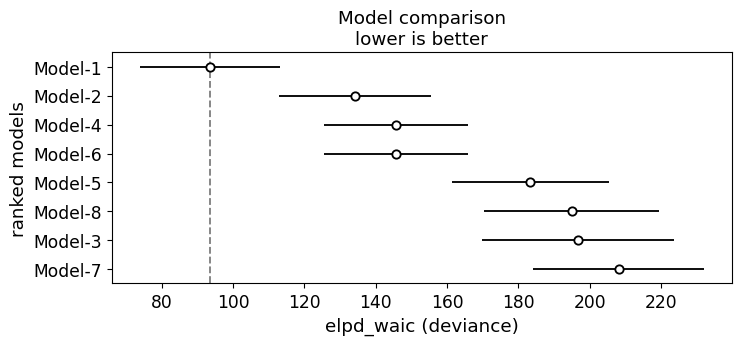

In [18]:
dict_idata = {'Model-1':idata_1, 'Model-2':idata_2,
              'Model-3':idata_3, 'Model-4':idata_4, 'Model-5':idata_5,'Model-6':idata_6, 
               'Model-7':idata_7,'Model-8':idata_8}
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(8, 3))

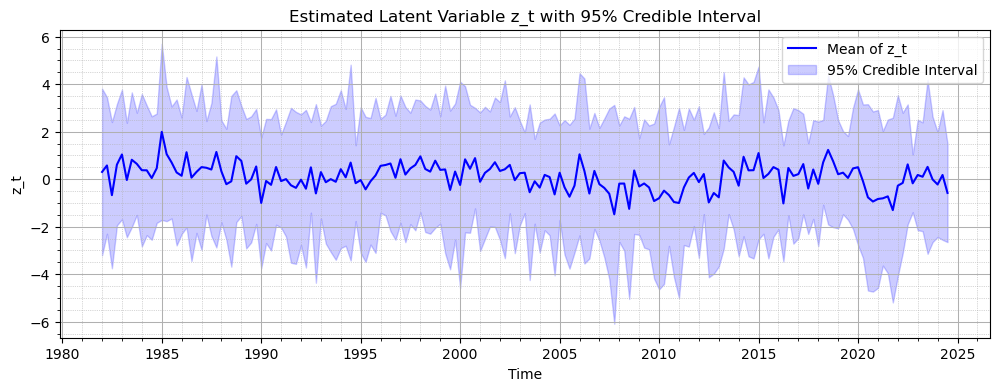

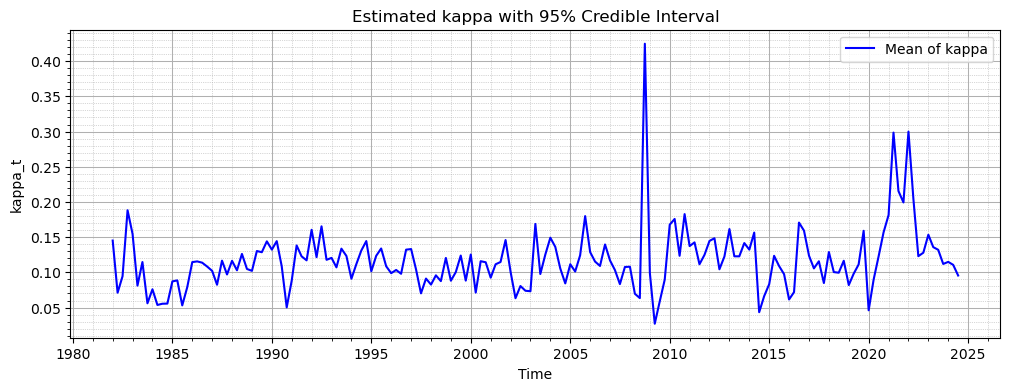

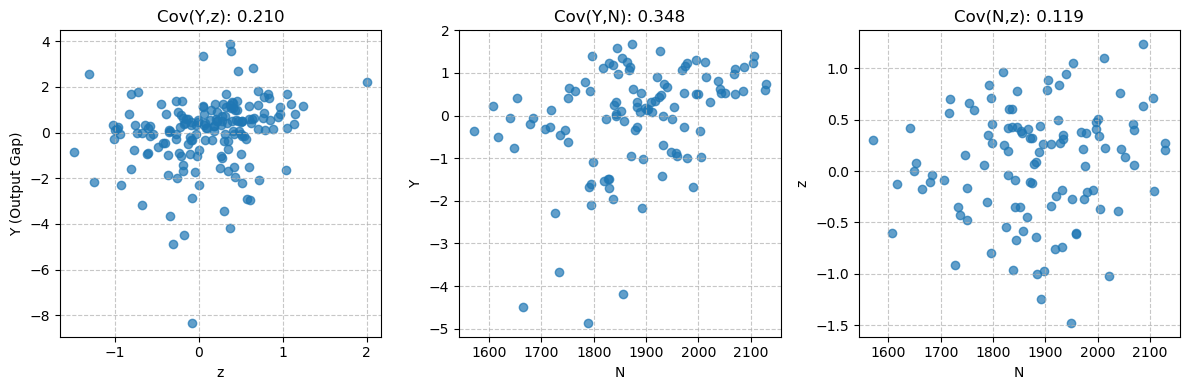

In [23]:
df = data
z_mean_value = z_mean_7
z_lower = z_lower_7
z_upper = z_upper_7
kappa_mean_value = kappa_mean_7
df["z"] = z_mean_value

data_N = pd.read_csv("data/BLS-bd-BDS0000000000000000120001LQ5.csv")
data_N["N_end"] = data_N["National – Gross Job Gains – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120001LQ5)"]
data_N["N"] = data_N["N_end"].shift(1)
data_N['q'] = data_N["period"]
data_N["q"] = data_N["q"].str.replace(" ", "")
data_N["DATE"] = data_N["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_N = data_N[["DATE", "N"]]
df_merged = pd.merge(df, data_N, on="DATE", how="outer")
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged["DATE"]<'2020-01-01']
# print(f"Bayesian R^2: {r2}")
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], z_mean_value, label="Mean of z_t", color="blue")
plt.fill_between(data["DATE"], z_lower, z_upper, color="blue", alpha=0.2, label="95% Credible Interval")
plt.title("Estimated Latent Variable z_t with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("z_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_value , label="Mean of kappa", color="blue")
plt.title("Estimated kappa with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
corrcoef1 = np.corrcoef(z_mean_value, data["Y"])[0, 1]
axes[0].scatter(z_mean_value, data["Y"], alpha=0.7)
axes[0].set_xlabel("z")
axes[0].set_ylabel("Y (Output Gap)")
axes[0].set_title(f"Cov(Y,z): {corrcoef1:.3f}")
axes[0].grid(True, linestyle='--', alpha=0.7)

corrcoef2 = np.corrcoef(df_merged["N"], df_merged["Y"])[0, 1]
axes[1].scatter(df_merged["N"], df_merged["Y"], alpha=0.7)
axes[1].set_xlabel("N")
axes[1].set_ylabel("Y")
axes[1].set_title(f"Cov(Y,N): {corrcoef2:.3f}")
axes[1].grid(True, linestyle='--', alpha=0.7)

corrcoef3 = np.corrcoef(df_merged["N"], df_merged["z"])[0, 1]
axes[2].scatter(df_merged["N"], df_merged["z"], alpha=0.7)
axes[2].set_xlabel("N")
axes[2].set_ylabel("z")
axes[2].set_title(f"Cov(N,z): {corrcoef3:.3f}")
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()